# Delay Relaxation and Cross Talk Errors
#### Ethan Dickey, Quantum Research Intern (Master's): Summer 2021
#### POC: Chris Wood

This notebook adds a customized `DelayAerSimulator` backend that extends `AerSimulator` to support simulation of both *parameterized delay noise* and *cross talk noise* in scheduled circuits.

It also provides a structure for adding generalized parameterized noise to a circuit (a functionality not currently supported by Qiskit simulators).

## TOC
- Motivation
- Implementation
  - DelayReplace
  - CrossTalkDelayReplace
  - Implementing other parameterized errors (how to)
- Simulation
  - Example
- Backend code
- \*Verification of CrossTalkDelayError via counts
- \*Verification of DelayReplace via counts
- Both Delay and Crosstalk noise counts
- \*Verification of DelayReplace via **T1 experiment**
  - T1 experiment with regular simulator backend
  - T1 experiment with this custom backend

\*For further verification of these passes, see "./Graphical Verification of Passes.ipynb"

## Motivation

Recently, the ability to schedule circuits was added to qiskit to reason about the duration and timing of instructions in circuits.  Scheduling a circuit, among other things, adds (duration-) parameterized delay gates into a circuit when a qubit is idle.  However, presently none of the simulators in qiskit have a way to add parameterized noise to a noise model.  They simply add noise based on the gates present in the circuit.  In addition, they don't have noise based on cross talk (when multiple connected qubits are in a delay).  This notebook demonstrates both a method to add single-qubit parameterized thermal relaxation errors as well as a method to add cross talk errors to a simulation.

Having these delay-based errors in a circuit is important for accurate noisy simulations as delays are a prolific part of every scheduled circuit.  For example, in a simple 4-qubit GHZ circuit, scheduling adds 6 delays (ish -- depends on how the qubits are connected).  In the first circuit drawing, you can see the many delays added to the original circuit.  For a different perspective, in the second circuit drawing everywhere there is grey is where scheduling adds a delay.

In [1]:
from qiskit.visualization.timeline import draw
from qiskit import QuantumCircuit, transpile
from qiskit.test.mock import FakeVigo

# Simulator backend
_delay_ex_backend = FakeVigo()

# Make a cirucit
_qc = QuantumCircuit(4)
_qc.h(0)
_qc.cx(0, 1)
_qc.cx(1, 2)
_qc.cx(2, 3)

# Schedule
_sched_circ = transpile(_qc, _delay_ex_backend, scheduling_method='alap')
_sched_circ.draw(fold=-1)

┌──────────────────┐                                                                                                               ┌───┐       
      q_3 -> 0 ┤ DELAY(15488[dt]) ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ X ├───────
               └┬────────────────┬┘                      ┌───┐                                                ┌───┐            ┌───┐              └─┬─┘       
      q_2 -> 1 ─┤ DELAY(160[dt]) ├────────────────────■──┤ X ├──■───────────■──────────────────────────────■──┤ X ├──■─────────┤ X ├────────────────■─────────
               ┌┴────────────────┤                    │  └─┬─┘  │         ┌─┴─┐       ┌─────────────────┐  │  └─┬─┘  │         └─┬─┘       ┌─────────────────┐
      q_1 -> 2 ┤ DELAY(6720[dt]) ├────────────────────┼────┼────┼─────────┤ X ├───────┤ DELAY(6560[dt]) ├──┼────┼────┼───────────■─────────┤ DELAY(2496[dt]) ├
               └───┬─────────┬───┘ ┌────┐┌─────────┐┌─┴─┐  │  ┌─┴─┐┌──────┴───┴──────┐└─────────────────┘┌─┴─┐  │  ┌─┴─┐┌─────────────────┐└─────────────────┘
      q_0 -> 3 ────┤ RZ(π/2) ├─────┤ √X ├┤ RZ(π/2) ├┤ X ├──■──┤ X ├┤ DELAY(1024[dt]) ├───────────────────┤ X ├──■──┤ X ├┤ DELAY(3680[dt]) ├───────────────────
               ┌───┴─────────┴────┐└────┘└─────────┘└───┘     └───┘└─────────────────┘                   └───┘     └───┘└─────────────────┘                   
ancilla_0 -> 4 ┤ DELAY(17984[dt]) ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
               └──────────────────┘

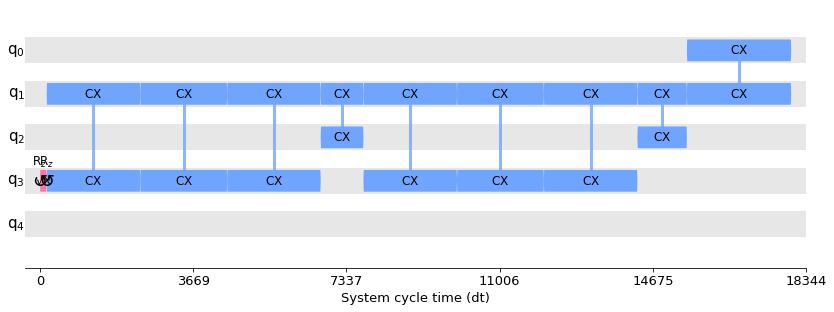

In [2]:
draw(_sched_circ)

## Implementation

The from_backend function allows this custom simulator to run additional passes after the circuit has been transpiled.  The two passes run are DelayReplace and CrossTalkDelayReplace.  After these passes finish running, a post processing step is applied which takes the analysis data from the DelayReplace pass (stored in the circuit metadata) and adds a duration-based thermal relaxation error to the noise model in the given simulator.

### DelayReplace

During this pass, analysis data regarding the delays and their durations is added to the circuit metadata.  This pass then adds a custom label to each delay gate so that the noise model can recognize delay errors based on their unique durations.

### CrossTalkDelayReplace

This pass first identifies when any qubit delay starts or stops and then uses that information to split all delays so that every delay lines up.  This allows the pass to then efficiently detect when two delays start together and add cross talk (via RZZ gate) *at the right time* if they are connected according to the coupling map.

### Implementing other parameterized errors (how to)

This code was written with the intent that someone could implement other parameterized errors and add them with the current structure.  First, create a custom pass that adds (not replaces) data to the circuit metadata under "transpiler_parameterized_error", which has this structure: `{tuple(labelString, qubitList): [paramList: float]}` where labelString is the custom label applied to the target gate, qubitList is the list of qubits that the gate applies to, and paramList is a list of floats representing the parameters you want to apply.  For reference, see the DelayReplace pass.

After this, the function add_transpiler_parameterized_errors deciphers this metadata list and utilizes a generator function to retrieve the right function to add pararmeterized errors.  To add you own errors, simply add your function to thermal_relaxation_function and return it instead of delay_error.  Your function must have the signature `fn(qubits, params) -> QuantumError`.

## Simulation

To simulate the parameterized delay errors and crosstalk errors with this backend:

1. The backend must contain a properties that includes T1, T2, and gate durations for all gates in the basis gates.

2. The simulator `cross_talk_noise` and/or `delay_noise` option must be set to `True` (this defaults to True if simulator is constructed using `DelayAerSimulator.from_backend`)

3. The input circuits must contain delay instructions to add errors to (ie. be scheduled using `transpile(circuits, backend, scheduling_method=val)`)

### Example
```python
# Device noise simulator
simulator = DelayAerSimulator.from_backend(real_backend)

# Schedule circuits
scheduled_circuits = transpile(circuits, simulator,
                               scheduling_method='alap')

# Run
result = simulator.run(scheduled_circuits).result()
```


## Backend code

In [3]:
#python
import copy
#qiskit
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.backends.aerbackend import AerBackend
from qiskit.providers.aer.noise import NoiseModel, thermal_relaxation_error
from qiskit.transpiler import PassManager
from qiskit import QuantumCircuit
#custom passes
from delayPasses.crossTalkPass import CrossTalkDelayReplace
from delayPasses.delayRelaxationPass import DelayReplace

#Custom backend simulator
class DelayAerSimulator(AerSimulator):
    ####*BEGIN* methods for post-processing the DelayReplace pass####
    #Define the noise model (to post-process the replaced delay gates into actual noise)
    def thermal_relaxation_function(self):
        """Return function for generating thermal relaxation errors.

        The returned function is used to generate thermal relaxation
        errors for delay instructions based on the qubit `T1`, `T2`
        properties, and `dt` time of the provided backend.

        Args:
            backend (Backend): A backend object.

        Returns:
            Callable: the delay error function with signature
                      ``fn(qubits, params) -> QuantumError```.
        """
        properties = self.properties()
        dt = self.configuration().dt


        def delay_error(qubits, params):
            """Return error instruction for delay on specified qubits.

            Args:
                qubits (List[int]): qubits to apply delay to.
                duration (List[float]): length one list of delay
                    duration param. The delay time is given by
                    ``params[0] * dt``.

            Returns:
                QuantumError: the error instruction.
            """
            time = params[0] * dt
            error = None
            for qubit in qubits:
                t1 = properties.t1(qubit)
                t2 = properties.t2(qubit)
                qubit_error = thermal_relaxation_error(t1, t2, time)
                if error is None:
                    error = qubit_error
                else:
                    error = error.expand(qubit_error)
            return error

        return delay_error
    
    def add_transpiler_parameterized_errors(self, circuits, noise_model=None):
        """Extracts the parameterized errors from each circuit's metadata and
            adds them to the noise model given.  Circuit should
            have been transpiled with the delay pass included for this to
            be useful.  Errors are characterized by which backend simulator
            is provided (currently only AerBackends are supported).

        Args:
            backend (Backend): An AerBackend instance to add the noise
                error to.
            circuits (QuantumCircuit(s)): Quantum circuits with metadata including
                the transpiler_parameterized_error field.
            noise_model: Noise model to use or else one is generated.

        Returns:
            None
        """

        # Look for existing noise model
        # Make a copy of noise model since we are appending it
        nm = copy.deepcopy(noise_model) or NoiseModel()


        #retrieve function to generate errors based on backend
        backend_delay_error = self.thermal_relaxation_function()

        if isinstance(circuits, QuantumCircuit):
            circuits = [circuits]

        for circuit in circuits:
            #Validate metadata
            if not circuit.metadata or 'transpiler_parameterized_error' not in circuit.metadata:
                print("Warning: One circuit does not have any parameterized errors")
                continue

            metadata = circuit.metadata.pop('transpiler_parameterized_error')
            qubit_indices = {qubit: idx for idx, qubit in enumerate(circuit.qubits)}

            #Add delay errors to noise model
            #  transpile_paramaterized_errors = {tuple(labelstring, qubitlist): paramlist: [float]}
            for (label, qubits), params in metadata.items():
                qargs = [qubit_indices[i] for i in qubits]
                error = backend_delay_error(qargs, params)

                # Add to noise model(QuantumError, label: String, [qubits])
                nm.add_quantum_error(error, label, qargs)
        return nm
    ####*END* methods for post-processing the DelayReplace pass####

    ####*BEGIN* Overridden AerSimulator methods####
    # Override methods of AerSimulator to add support for automatically
    # extending the noise model with errors for the parameterized gates

    @classmethod
    def _default_options(cls):
        # Add delay option defaulting to false
        opts = AerSimulator._default_options()
        
        #DelayReplace
        opts.delay_noise = False
        #CrossTalkDelayReplace
        opts.cross_talk_noise = False
        opts.theta = 0
        
        return opts

    @classmethod
    def from_backend(cls, backend, **options):
        """Initialize simulator from backend."""

        # Add delay noise option
        if 'delay_noise' not in options:
            options['delay_noise'] = True

        # Add cross talk noise option
        if 'cross_talk_noise' not in options:
            options['cross_talk_noise'] = True
        # Add theta specification option
        if 'theta' not in options:
            options['theta'] = 0.1

        # Get configuration and properties from backend
        configuration = copy.copy(backend.configuration())
        properties = copy.copy(backend.properties())

        # Customize configuration name
        name = configuration.backend_name
        configuration.backend_name = 'aer_simulator({})'.format(name)

        # Use automatic noise model if none is provided
        if 'noise_model' not in options:
            noise_model = NoiseModel.from_backend(backend)
            if not noise_model.is_ideal():
                options['noise_model'] = noise_model

        # Initialize simulator
        sim = cls(configuration=configuration,
                  properties=properties,
                  **options)
        return sim
    ####*END* Overridden AerSimulator methods####
    
    ####RUN METHOD####
    # pylint: disable=arguments-differ
    def run(self, circuits, validate=False, **run_options):
        
        # Pre-process parameterized error options
        options = copy.deepcopy(run_options)
        ## DelayReplace
        if 'delay_noise' in options:
            delay_noise = options.pop('delay_noise')
        else:
            delay_noise = self.options.delay_noise
        ## CrossTalk
        if 'cross_talk_noise' in options:
            cross_talk_noise = options.pop('cross_talk_noise')
        else:
            cross_talk_noise = self.options.cross_talk_noise
        if 'theta' in options:
            theta = options.pop('theta')
        else:
            theta = self.options.theta
        ## Both
        if 'noise_model' in options:
            noise_model = options.pop('noise_model')
        else:
            noise_model = self.options.noise_model
    
        #Do the scheduling
        pm = PassManager()

        # Add cross talk noise scheduling
        if cross_talk_noise:
            # Run custom transpiler pass to handle cross talk
            pm.append([CrossTalkDelayReplace(super().configuration().coupling_map, theta)])
        # Add delay noise scheduling
        if delay_noise:
            # Run custom transpiler pass to replace delays
            pm.append([DelayReplace()])
        
        if cross_talk_noise or delay_noise:
            circuits = pm.run(circuits)

        if delay_noise:
            # Add parameterized errors to noise model
            noise_model = self.add_transpiler_parameterized_errors(circuits, noise_model)

        # Run noisy simulation
        return super().run(circuits, validate=validate, noise_model=noise_model, **options)

## Verification of CrossTalkDelayError via counts

The following code runs only the cross talk part of the custom backend without any other noise (noise_model set to none) and compares the counts with counts from the same simulation without crosstalk added.  The circuit used is one meant to draw out the cross talk error by putting all qubits in a superposition and then delaying all of them the same amount and then measuring only one of them.

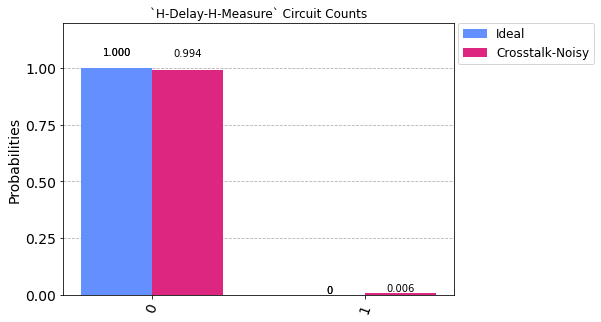

In [4]:
from qiskit import QuantumCircuit, transpile
from qiskit.test.mock import FakeVigo
from qiskit.visualization import plot_histogram

# Simulator backend
target_backend = FakeVigo()
backend = DelayAerSimulator.from_backend(target_backend,
                                         noise_model=None,
#                                          cross_talk_noise=False,
                                         delay_noise=False,
                                        )
#Create circuit
delay_test_length = 200000
qc_crosstalk = QuantumCircuit(5, 1)
qc_crosstalk.h(range(5))
qc_crosstalk.barrier(range(5))
qc_crosstalk.delay(delay_test_length, range(5))
qc_crosstalk.barrier(range(5))
qc_crosstalk.h(range(5))
qc_crosstalk.measure(1, 0)

# Schedule and view
sched_circ_crosstalk = transpile(qc_crosstalk, backend, scheduling_method='alap')
#for visualization purposes, uncomment
# sched_circ_crosstalk.draw(fold=-1)
# draw(sched_circ_crosstalk)

# Run using custom backend
shots = 10000
result_noise = backend.run([sched_circ_crosstalk], shots=shots).result()
counts_noise = result_noise.get_counts(0)

#ideal
backend = DelayAerSimulator.from_backend(target_backend,
                                         noise_model=None,
                                         cross_talk_noise=False,
                                         delay_noise=False,
                                        )
sched_sim_ideal = transpile(qc_crosstalk, backend, scheduling_method='alap')
result_ideal = backend.run([sched_sim_ideal], shots=shots).result()
counts_ideal = result_ideal.get_counts(0)

plot_histogram([counts_ideal, counts_noise], title="`H-Delay-H-Measure` Circuit Counts", legend=["Ideal", "Crosstalk-Noisy"])

## Verification of DelayReplace via counts

The following code runs only the cross talk part of the custom backend without any other noise (noise_model set to none) and compares the counts with counts from the same simulation without crosstalk added.  The circuit used is a simple GHZ circuit with measurements on all qubits.

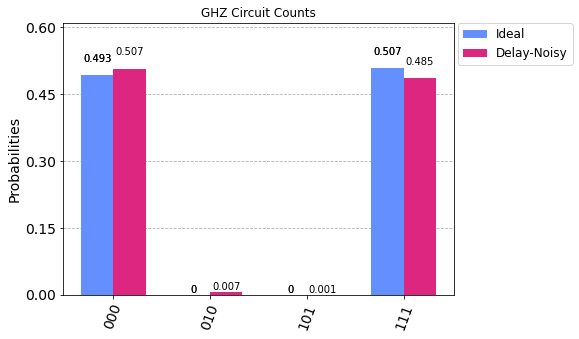

In [5]:
from qiskit import QuantumCircuit, transpile
from qiskit.test.mock import FakeVigo
from qiskit.visualization import plot_histogram

# Simulator backend
target_backend = FakeVigo()
backend = DelayAerSimulator.from_backend(target_backend,
                                         noise_model=None,
                                         cross_talk_noise=False,
#                                          delay_noise=False,
                                        )
#Create circuit
qc_delaynoise = QuantumCircuit(3)
qc_delaynoise.h(0)
qc_delaynoise.cx(0, 1)
qc_delaynoise.cx(0, 2)
qc_delaynoise.measure_all()

# Schedule and view
sched_circ_delaynoise = transpile(qc_delaynoise, backend, scheduling_method='alap')
#for visualization purposes, uncomment
# sched_circ_delaynoise.draw(fold=-1)
# draw(sched_circ_delaynoise)

# Run using custom backend
shots = 10000
result_noise = backend.run([sched_circ_delaynoise], shots=shots).result()
counts_noise = result_noise.get_counts(0)

#ideal
backend = DelayAerSimulator.from_backend(target_backend,
                                         noise_model=None,
                                         cross_talk_noise=False,
                                         delay_noise=False,
                                        )
sched_sim_ideal = transpile(qc_delaynoise, backend, scheduling_method='alap')
result_ideal = backend.run([sched_sim_ideal], shots=shots).result()
counts_ideal = result_ideal.get_counts(0)

plot_histogram([counts_ideal, counts_noise], title="GHZ Circuit Counts", legend=["Ideal", "Delay-Noisy"])

## Both Delay and Crosstalk noise counts

Both of the above sections combined.  This is really just to see them all on the same graph :).

The H-Delay-H-Measure circuit was chosen to amplify the crosstalk noise.

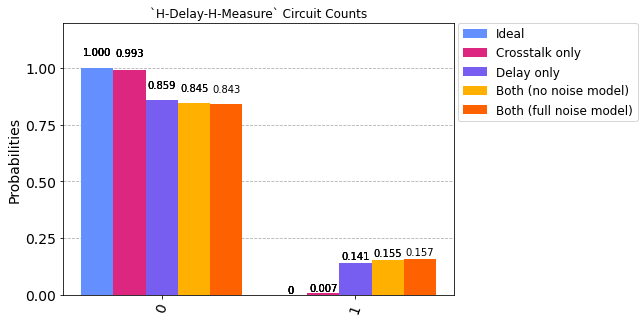

In [12]:
from qiskit import QuantumCircuit, transpile
from qiskit.test.mock import FakeVigo
from qiskit.visualization import plot_histogram

#Create circuit
delay_test_length = 200000
num_qubits = 5
qc_all = QuantumCircuit(num_qubits, 1)
qc_all.h(range(num_qubits))
qc_all.barrier(range(num_qubits))
qc_all.delay(delay_test_length, range(num_qubits))
qc_all.barrier(range(num_qubits))
qc_all.h(range(num_qubits))
qc_all.measure(1, 0)


# Simulator backends
target_backend = FakeVigo()
backend_ideal = DelayAerSimulator.from_backend(target_backend,
                                         noise_model=None,
                                         cross_talk_noise=False,
                                         delay_noise=False,
                                        )
backend_crosstalk_only = DelayAerSimulator.from_backend(target_backend,
                                         noise_model=None,
#                                          cross_talk_noise=False,
                                         delay_noise=False,
                                        )
backend_delay_only = DelayAerSimulator.from_backend(target_backend,
                                         noise_model=None,
                                         cross_talk_noise=False,
#                                          delay_noise=False,
                                        )
backend_both = DelayAerSimulator.from_backend(target_backend,
                                         noise_model=None,
#                                          cross_talk_noise=False,
#                                          delay_noise=False,
                                        )
backend_both_with_full_noise_model = DelayAerSimulator.from_backend(target_backend,
#                                          noise_model=None,
#                                          cross_talk_noise=False,
#                                          delay_noise=False,
                                        )

# Schedule and view
sched_circ_ideal = transpile(qc_all, backend_ideal, scheduling_method='alap')
sched_circ_crosstalk = transpile(qc_all, backend_crosstalk_only, scheduling_method='alap')
sched_circ_delay = transpile(qc_all, backend_delay_only, scheduling_method='alap')
sched_circ_both = transpile(qc_all, backend_both, scheduling_method='alap')
sched_circ_full_noise = transpile(qc_all, backend_both_with_full_noise_model, scheduling_method='alap')

# Run using custom backend
shots = 10000
counts_ideal = backend_ideal.run([sched_circ_ideal], shots=shots).result().get_counts(0)
counts_crosstalk = backend_crosstalk_only.run([sched_circ_crosstalk], shots=shots).result().get_counts(0)
counts_delay = backend_delay_only.run([sched_circ_delay], shots=shots).result().get_counts(0)
counts_both = backend_both.run([sched_circ_both], shots=shots).result().get_counts(0)
counts_full_noise = backend_both_with_full_noise_model.run([sched_circ_full_noise], shots=shots).result().get_counts(0)

plot_histogram([counts_ideal, counts_crosstalk, counts_delay, counts_both, counts_full_noise],
               title="`H-Delay-H-Measure` Circuit Counts",
               legend=["Ideal", "Crosstalk only", "Delay only", "Both (no noise model)", "Both (full noise model)"])


## Verification of DelayReplace via **T1 experiment**

### T1 experiment with a regular simulator backend

This requires installing the `qiskit-experiments` package from https://github.com/Qiskit/qiskit-experiments

The following code is based on the example usage of the T1 experiments at https://qiskit.org/documentation/experiments/tutorials/t1.html, but with my custom backend instead of a T1 example backend.

In [7]:
import numpy as np
from qiskit_experiments.library import T1

In [8]:
# Simulator backend
target_backend = FakeVigo()
backend_delaynoise = DelayAerSimulator.from_backend(target_backend,
                                         noise_model=None,
                                         cross_talk_noise=False,
#                                          delay_noise=False,
                                        )
properties = backend_delaynoise.properties()

# Check backend recorded T1 of qubit-0 (this should be in 's' units)
t1_qubit0 = properties.t1(0)
t1_qubit0

0.00012170801410836628

Adding a job from a backend (qasm_simulator) that is different than the current backend (fake_vigo). The new backend will be used, but service is not changed if one already exists.


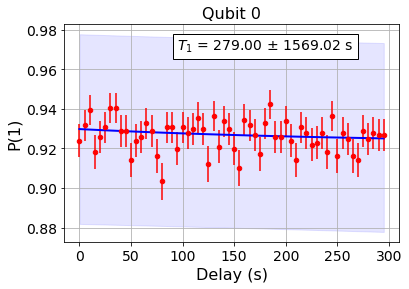

DbAnalysisResultV1
- name: T1
- value: 279.00387589961537 ± 1569.0173382920862 s
- χ²: 0.9357058989519446
- quality: bad
- extra: <9 items>
- device_components: ['Q0']
- verified: False


In [9]:
delays = list(range(0, 300, 5))

# T1 Experiment on a typical backend
_t1exp = T1(qubit=0, delays=delays, unit='s')
_t1data = _t1exp.run(backend=target_backend, shots=1000).block_for_results()

# Print analysis results
display(_t1data.figure(0))
_t1result = _t1data.analysis_results(-1)
print(_t1result)

Note the "quality: bad"

### T1 experiment with this custom backend

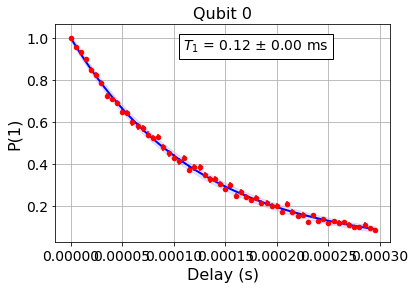

DbAnalysisResultV1
- name: T1
- value: 0.00012132516703998549 ± 2.7092089942158126e-06 s
- χ²: 0.00015389528334305405
- quality: good
- extra: <9 items>
- device_components: ['Q0']
- verified: False


In [10]:
# T1 experiment on qubit 0
t1exp = T1(qubit=0, delays=delays, unit='us')

# Run on the delay-noise backend
t1data = t1exp.run(backend=backend_delaynoise, shots=1000).block_for_results()

# Print analysis results
#   NOTE: if delay noise is correct this should show a plot of exponential decay
#   and fit a value close to the `t1_qubit0` target
display(t1data.figure(0))
t1result = t1data.analysis_results(-1)
print(t1result)

Note the "quality: good"

Excellent exponential decay agreement!  The recorded value of T1, for reference is

In [11]:
t1_qubit0

0.00012170801410836628

\****For a further graphical analysis and verification of these passes, see "./Graphical Verification of Passes.ipynb"***